# Model Evaluation

In this notebook, we will test multiple model and evaluate to choose the best one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

In [2]:
# Importing data
X = pd.read_pickle('PKL/X_train.pkl')
y = pd.read_pickle('PKL/Y_train.pkl')

## Train/Test Split
We will split the train data once more. It's because this is a competition dataset and we actually don't have the 'test' score result. So we will use the test set we created from the initial training set as a holdout set to actually see our performance of the final model. The final test set, which we don't have the labels for, will be used to make a prediction in the final testing notebook. 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.2)

In [4]:
# Turning all categorical features to dummies 
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

In [5]:
# Check if training and testing sets have the same features
if X_train_ohe.shape[1] != X_test_ohe.shape[1]:
    print([x for x in X_train_ohe.columns if x not in X_test_ohe.columns])
    print([x for x in X_test_ohe.columns if x not in X_train_ohe.columns])
else: 
    print ('Good to go')

Good to go


In [6]:
# If they are not the same, add the column with 0s and fix the order
# X_test_ohe[colname] = 0
# X_test_ohe = X_test_ohe[X_train_ohe.columns]

## Class Imbalance Issue
Our dataset has high class imbalance issue. We will mostly deal with this by setting the class weight within each model, otherwise mentioned (in some cases where imbalance weight is not adequately dealt with by algorithm we test with SMOTE).

## Evaluation Metrics
Our target is multi-class with imbalance issue. We will use the weighted f1 score to capture the predictive performance for overall classes. It calculates the f1 score for each class and find the average weighted by the number of actual positive cases in each class, so naturally penalizes if minority recall is low. For more specific measure to focus on the imbalance of minority classes, I will use balanced accuracy score. This computes the average accuracy score weighted by the inverse prevalence of the true class. So it accounts for the imbalance for rigorously then the weighted f1 score, which only takes the number of positive cases into account.

In terms of prediction within each class, we rather want to overpredict 'needs repair' or 'non functional' cases (minorities) than the functional cases. Because the condition of the well is crucial for survival of surrounding population. Specifically, we want the recall of the non functional and needs repair cases to be high because false positive of minority classes is better than missing those actually positive classes. I will look at this breakdown using the classification report.

Additionally we will plot confusion matrix to understand some of the scores better.

In [46]:
from sklearn.metrics import f1_score, balanced_accuracy_score, plot_confusion_matrix, classification_report

## Dummy Classifier
We'll first create a dummy classifier as a baseline score.

In [47]:
#keeping score
score_keeper = {}

In [8]:
from sklearn.dummy import DummyClassifier
dummyc = DummyClassifier(strategy = 'stratified') # using the default stratified strategy
dummyc.fit(X_train_ohe, y_train)
y_pred = dummyc.predict(X_test_ohe)

f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)
print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['baseline'] = (f1_test, acc_test)


Test F1 score:  0.44 / Test Accuracy:  0.335


                         precision    recall  f1-score   support

             functional       0.54      0.55      0.54      4822
functional needs repair       0.09      0.08      0.08       678
         non functional       0.37      0.36      0.36      3410

               accuracy                           0.44      8910
              macro avg       0.33      0.33      0.33      8910
           weighted avg       0.44      0.44      0.44      8910



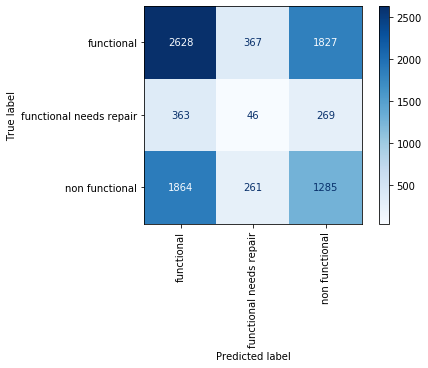

In [9]:
plot_confusion_matrix(dummyc, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Our stratified dummy classifier shows the weighted F1 score around .45 but less balanced accuracy. Dummy classifier is consistently wrong on all cases but recall for minority classes are especially bad.

## KNN
Now we will run K-Nearest Neighbors using GridSearchCV. 

### Standardization
For KNN, all feature values need to be standardized.

In [9]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train_ohe)
X_test_scaled = scale.transform(X_test_ohe)

Finding the optimal hyperparameters using GridSearchCV.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
    'n_neighbors': range(1, 16, 2), # setting K
}

knc = KNeighborsClassifier(weights = 'distance') 
knc_g = GridSearchCV(knc, params, cv = 5, scoring = 'f1_weighted', verbose = 1, n_jobs = -1)
knc_g.fit(X_train_scaled, y_train)
print(knc_g.best_params_, ': ', knc_g.best_score_)

In [ ]:
# saving the model 
#mod = open('PKL/knn_gsc.pkl', 'wb')
#pickle.dump(knc_g.best_estimator_, mod)
#mod.close()

In [48]:
# Reload the model
#knc_g = pickle.load(open('PKL/knn_gsc.pkl', 'rb'))

In [51]:
# KNN performance on the test set
y_pred = knc_g.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_gsc'] = (f1_test, acc_test)
print(classification_report(y_test, y_pred))

Test F1 score:  0.749 / Test Accuracy:  0.623
                         precision    recall  f1-score   support

             functional       0.78      0.83      0.80      4822
functional needs repair       0.45      0.30      0.36       678
         non functional       0.76      0.74      0.75      3410

               accuracy                           0.76      8910
              macro avg       0.66      0.62      0.64      8910
           weighted avg       0.75      0.76      0.75      8910



In [54]:
y_train_pred = knc_g.predict(X_train_scaled)    
f1_test = round(f1_score(y_train, y_train_pred, average = 'weighted'), 3)
#f1_test

Overall improvement from the dummy model, but the recall of needs repair class is still low. Looking at training score (.99) shows that it's highly overfitting. In this document we'll see if different optimization method finds a better hyperparameter. 
In 030B file, we explore more into limiting features using random forest feature selection for KNN as KNN does not select features and can make the model messy. As a summary, after Random Forest feature selection, the performance didn't improve, but also didn't drop. So we know for KNN those extra features were unnecessarily complicating our model. For the sake of keeping it consistent with the rest of models, we will keep all features (they have been already selected based on intuition in the EDA notebook) for now.

### Optimization Method
Now we want to try different optimization method to make sure we have the best hyperparmeter for KNN. This time we'll use optuna to explore even more hyperparameters. We'll cap the time to what it took to run the GridSearch above.

In [11]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [18]:
def find_hyperp_KNN(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 31)
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree'])
    leaf_size = trial.suggest_int('leaf_size', 2, 60)
    p = trial.suggest_categorical('p', [1, 2])
    knc = KNeighborsClassifier(weights = 'distance', 
                             n_neighbors = n_neighbors, 
                             algorithm = algorithm, 
                             leaf_size = leaf_size, 
                             p = p)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(knc, X_train_scaled, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

#knn_study = optuna.create_study(direction='maximize')
#knn_study.optimize(find_hyperp_KNN, timeout = 16*60)

[I 2020-08-19 13:08:55,419] Trial 0 finished with value: 0.7485009501531509 and parameters: {'n_neighbors': 15, 'algorithm': 'kd_tree', 'leaf_size': 25, 'p': 1}. Best is trial 0 with value: 0.7485009501531509.
[I 2020-08-19 13:13:16,183] Trial 1 finished with value: 0.7509255320226023 and parameters: {'n_neighbors': 11, 'algorithm': 'ball_tree', 'leaf_size': 34, 'p': 1}. Best is trial 1 with value: 0.7509255320226023.
[I 2020-08-19 13:15:54,786] Trial 2 finished with value: 0.7484556998711398 and parameters: {'n_neighbors': 5, 'algorithm': 'kd_tree', 'leaf_size': 53, 'p': 1}. Best is trial 1 with value: 0.7509255320226023.
[I 2020-08-19 13:19:29,315] Trial 3 finished with value: 0.7468511291107374 and parameters: {'n_neighbors': 20, 'algorithm': 'kd_tree', 'leaf_size': 11, 'p': 1}. Best is trial 1 with value: 0.7509255320226023.
[I 2020-08-19 13:24:45,069] Trial 4 finished with value: 0.7289320247819362 and parameters: {'n_neighbors': 30, 'algorithm': 'ball_tree', 'leaf_size': 5, 'p': 

In [19]:
# saving the study 
#mod = open('PKL/knn_study.pkl', 'wb')
#pickle.dump(knn_study, mod)
#mod.close()

In [56]:
# Reload the study
#knn_study = pickle.load(open('PKL/knn_study.pkl', 'rb'))

In [57]:
# Testing the best params on the test set
knc_opt = KNeighborsClassifier(**knn_study.best_params, weights = 'distance')
knc_opt.fit(X_train_scaled, y_train)

y_pred = knc_opt.predict(X_test_scaled)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['knn_opt'] = (f1_test, acc_test)
#plot_confusion_matrix(knc_opt, X_test_scaled, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

Test F1 score:  0.759 / Test Accuracy:  0.63
                         precision    recall  f1-score   support

             functional       0.78      0.84      0.81      4822
functional needs repair       0.46      0.30      0.36       678
         non functional       0.78      0.75      0.76      3410

               accuracy                           0.77      8910
              macro avg       0.67      0.63      0.65      8910
           weighted avg       0.76      0.77      0.76      8910



Recall score for the needs repair class is still low but the overall performance and recall for non-functional improved slightly.

## Random Forest 
Since Optuna performance was better above, now we'll try running random forest using Optuna. Since we have a lot of features, tree-based model might deal better by ignoring not important features.

In [12]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [25]:
def find_hyperparam_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 0, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    max_features = trial.suggest_int('max_features', 2, 20)
    rfc = RandomForestClassifier(oob_score = True, 
                             n_estimators = n_estimators, 
                             max_depth = max_depth, 
                             min_samples_split = min_samples_split, 
                             min_samples_leaf = min_samples_leaf, 
                             criterion = criterion, 
                             class_weight = class_weight, 
                             max_features = max_features)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(rfc, X_train_ohe, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

#rfc_study = optuna.create_study(direction='maximize')
#rfc_study.optimize(find_hyperparam_rf, timeout = 60*60*4) # run it for 4 hours

[I 2020-08-19 13:31:34,225] Trial 0 finished with value: 0.6435736370995105 and parameters: {'n_estimators': 214, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 15, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 13}. Best is trial 0 with value: 0.6435736370995105.
[W 2020-08-19 13:31:36,762] Trial 1 failed, because the objective function returned nan.
[I 2020-08-19 13:31:48,690] Trial 2 finished with value: 0.667948024785022 and parameters: {'n_estimators': 141, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 7}. Best is trial 2 with value: 0.667948024785022.
[W 2020-08-19 13:31:50,049] Trial 3 failed, because the objective function returned nan.
[I 2020-08-19 13:31:56,029] Trial 4 finished with value: 0.6060618375634556 and parameters: {'n_estimators': 72, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 13, 'criterion': 'entropy', 'class_weight': 'bal

[I 2020-08-19 13:38:34,937] Trial 38 finished with value: 0.6880815213189635 and parameters: {'n_estimators': 268, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 19 with value: 0.6997594959349274.
[W 2020-08-19 13:38:36,434] Trial 39 failed, because the objective function returned nan.
[W 2020-08-19 13:38:37,903] Trial 40 failed, because the objective function returned nan.
[W 2020-08-19 13:38:39,373] Trial 41 failed, because the objective function returned nan.
[I 2020-08-19 13:39:10,337] Trial 42 finished with value: 0.6970782447742284 and parameters: {'n_estimators': 297, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 19 with value: 0.6997594959349274.
[W 2020-08-19 13:39:11,812] Trial 43 failed, because the objective function returned nan.
[I 2020-08-19 13:39:38,102] Trial 44 fin

[W 2020-08-19 13:42:35,539] Trial 114 failed, because the objective function returned nan.
[I 2020-08-19 13:42:55,900] Trial 115 finished with value: 0.6920898702024423 and parameters: {'n_estimators': 204, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 16}. Best is trial 19 with value: 0.6997594959349274.
[W 2020-08-19 13:42:57,449] Trial 116 failed, because the objective function returned nan.
[W 2020-08-19 13:42:58,924] Trial 117 failed, because the objective function returned nan.
[W 2020-08-19 13:43:00,387] Trial 118 failed, because the objective function returned nan.
[W 2020-08-19 13:43:01,828] Trial 119 failed, because the objective function returned nan.
[I 2020-08-19 13:43:21,131] Trial 120 finished with value: 0.6701851995564967 and parameters: {'n_estimators': 236, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 

[I 2020-08-19 13:53:09,384] Trial 146 finished with value: 0.6980054842521749 and parameters: {'n_estimators': 197, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 138 with value: 0.701570251339292.
[I 2020-08-19 13:53:36,315] Trial 147 finished with value: 0.697795925411857 and parameters: {'n_estimators': 259, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 138 with value: 0.701570251339292.
[I 2020-08-19 13:53:53,529] Trial 148 finished with value: 0.6968689059709247 and parameters: {'n_estimators': 157, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 138 with value: 0.701570251339292.
[I 2020-08-19 13:54:17,572] Trial 149 finished with value: 0.6821863204708922 and parameters: {'n

[I 2020-08-19 14:03:41,611] Trial 175 finished with value: 0.6984975949184747 and parameters: {'n_estimators': 254, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 19}. Best is trial 159 with value: 0.7016848549172436.
[I 2020-08-19 14:04:08,289] Trial 176 finished with value: 0.6916681504071412 and parameters: {'n_estimators': 262, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 11, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 17}. Best is trial 159 with value: 0.7016848549172436.
[W 2020-08-19 14:04:09,730] Trial 177 failed, because the objective function returned nan.
[W 2020-08-19 14:04:11,169] Trial 178 failed, because the objective function returned nan.
[I 2020-08-19 14:04:31,251] Trial 179 finished with value: 0.6979258107164658 and parameters: {'n_estimators': 186, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_wei

[I 2020-08-19 14:13:25,186] Trial 208 finished with value: 0.6989789901498176 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 18}. Best is trial 159 with value: 0.7016848549172436.
[I 2020-08-19 14:13:54,136] Trial 209 finished with value: 0.6991164015415325 and parameters: {'n_estimators': 275, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 17}. Best is trial 159 with value: 0.7016848549172436.
[W 2020-08-19 14:13:55,610] Trial 210 failed, because the objective function returned nan.
[I 2020-08-19 14:14:22,908] Trial 211 finished with value: 0.6971862445264195 and parameters: {'n_estimators': 257, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 19}. Best is trial 159 with value: 0.7016848549172436.
[I 

[I 2020-08-19 14:24:21,028] Trial 240 finished with value: 0.7003011372419101 and parameters: {'n_estimators': 242, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 232 with value: 0.7019554642537044.
[I 2020-08-19 14:24:48,868] Trial 241 finished with value: 0.6997860968566514 and parameters: {'n_estimators': 247, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 232 with value: 0.7019554642537044.
[I 2020-08-19 14:25:15,208] Trial 242 finished with value: 0.7017253665879849 and parameters: {'n_estimators': 241, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 19}. Best is trial 232 with value: 0.7019554642537044.
[I 2020-08-19 14:25:42,127] Trial 243 finished with value: 0.7014976406921205 and parameters: 

[I 2020-08-19 14:35:33,153] Trial 271 finished with value: 0.7030000996292343 and parameters: {'n_estimators': 249, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 271 with value: 0.7030000996292343.
[I 2020-08-19 14:36:00,836] Trial 272 finished with value: 0.7005138364688092 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 271 with value: 0.7030000996292343.
[I 2020-08-19 14:36:29,087] Trial 273 finished with value: 0.6928084515564522 and parameters: {'n_estimators': 263, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 13, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 271 with value: 0.7030000996292343.
[I 2020-08-19 14:36:56,183] Trial 274 finished with value: 0.7034066754106837 and parameters:

[I 2020-08-19 14:47:08,865] Trial 299 finished with value: 0.7016738525092846 and parameters: {'n_estimators': 243, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 274 with value: 0.7034066754106837.
[I 2020-08-19 14:47:35,218] Trial 300 finished with value: 0.6977776500581225 and parameters: {'n_estimators': 244, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 19}. Best is trial 274 with value: 0.7034066754106837.
[W 2020-08-19 14:47:36,641] Trial 301 failed, because the objective function returned nan.
[W 2020-08-19 14:47:38,081] Trial 302 failed, because the objective function returned nan.
[I 2020-08-19 14:47:45,676] Trial 303 finished with value: 0.6988496985314326 and parameters: {'n_estimators': 58, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weig

[I 2020-08-19 14:58:18,675] Trial 333 finished with value: 0.7007284652927006 and parameters: {'n_estimators': 277, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 331 with value: 0.7037458272566832.
[I 2020-08-19 14:58:47,457] Trial 334 finished with value: 0.7007124580550267 and parameters: {'n_estimators': 264, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 331 with value: 0.7037458272566832.
[W 2020-08-19 14:58:48,940] Trial 335 failed, because the objective function returned nan.
[W 2020-08-19 14:58:50,438] Trial 336 failed, because the objective function returned nan.
[W 2020-08-19 14:58:51,932] Trial 337 failed, because the objective function returned nan.
[I 2020-08-19 14:59:20,609] Trial 338 finished with value: 0.7030925213132168 and parameters: {'n_estimators': 259, 'max_

[I 2020-08-19 15:10:19,756] Trial 367 finished with value: 0.699790039747544 and parameters: {'n_estimators': 290, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 331 with value: 0.7037458272566832.
[I 2020-08-19 15:10:50,607] Trial 368 finished with value: 0.7003612012179989 and parameters: {'n_estimators': 282, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 331 with value: 0.7037458272566832.
[W 2020-08-19 15:10:52,064] Trial 369 failed, because the objective function returned nan.
[I 2020-08-19 15:11:22,899] Trial 370 finished with value: 0.6997005554078811 and parameters: {'n_estimators': 287, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 19}. Best is trial 331 with value: 0.7037458272566832.
[

[I 2020-08-19 15:23:07,534] Trial 395 finished with value: 0.7005466052233957 and parameters: {'n_estimators': 270, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 386 with value: 0.704258407906919.
[I 2020-08-19 15:23:40,310] Trial 396 finished with value: 0.7018414642778823 and parameters: {'n_estimators': 291, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 386 with value: 0.704258407906919.
[I 2020-08-19 15:24:11,717] Trial 397 finished with value: 0.6998378735062072 and parameters: {'n_estimators': 290, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced', 'max_features': 20}. Best is trial 386 with value: 0.704258407906919.
[W 2020-08-19 15:24:13,198] Trial 398 failed, because the objective function returned nan.
[W 2

[W 2020-08-19 15:34:14,231] Trial 434 failed, because the objective function returned nan.
[W 2020-08-19 15:34:15,685] Trial 435 failed, because the objective function returned nan.
[I 2020-08-19 15:34:47,759] Trial 436 finished with value: 0.7004613063345433 and parameters: {'n_estimators': 272, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 386 with value: 0.704258407906919.
[W 2020-08-19 15:34:49,205] Trial 437 failed, because the objective function returned nan.
[W 2020-08-19 15:34:50,684] Trial 438 failed, because the objective function returned nan.
[W 2020-08-19 15:34:52,138] Trial 439 failed, because the objective function returned nan.
[I 2020-08-19 15:35:26,470] Trial 440 finished with value: 0.7007075108674062 and parameters: {'n_estimators': 276, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsa

[I 2020-08-19 15:44:16,829] Trial 482 finished with value: 0.69962592172004 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 386 with value: 0.704258407906919.
[I 2020-08-19 15:44:49,943] Trial 483 finished with value: 0.7018867560330402 and parameters: {'n_estimators': 278, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 386 with value: 0.704258407906919.
[W 2020-08-19 15:44:51,400] Trial 484 failed, because the objective function returned nan.
[W 2020-08-19 15:44:52,870] Trial 485 failed, because the objective function returned nan.
[I 2020-08-19 15:45:26,625] Trial 486 finished with value: 0.702254618384001 and parameters: {'n_estimators': 279, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entrop

[I 2020-08-19 15:51:39,902] Trial 542 finished with value: 0.7008733925093076 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 15:51:41,389] Trial 543 failed, because the objective function returned nan.
[W 2020-08-19 15:51:42,870] Trial 544 failed, because the objective function returned nan.
[W 2020-08-19 15:51:44,325] Trial 545 failed, because the objective function returned nan.
[W 2020-08-19 15:51:45,823] Trial 546 failed, because the objective function returned nan.
[I 2020-08-19 15:52:18,228] Trial 547 finished with value: 0.6988039389093708 and parameters: {'n_estimators': 265, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[I 2020-08-1

[W 2020-08-19 15:58:54,209] Trial 600 failed, because the objective function returned nan.
[I 2020-08-19 15:59:25,998] Trial 601 finished with value: 0.7013567303888004 and parameters: {'n_estimators': 272, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 15:59:27,474] Trial 602 failed, because the objective function returned nan.
[W 2020-08-19 15:59:28,940] Trial 603 failed, because the objective function returned nan.
[W 2020-08-19 15:59:30,428] Trial 604 failed, because the objective function returned nan.
[W 2020-08-19 15:59:31,898] Trial 605 failed, because the objective function returned nan.
[W 2020-08-19 15:59:33,351] Trial 606 failed, because the objective function returned nan.
[W 2020-08-19 15:59:34,831] Trial 607 failed, because the objective function returned nan.
[I 2020-08-19 16:00:07,235] Trial 608 finished with va

[W 2020-08-19 16:04:21,364] Trial 673 failed, because the objective function returned nan.
[W 2020-08-19 16:04:22,836] Trial 674 failed, because the objective function returned nan.
[I 2020-08-19 16:04:54,850] Trial 675 finished with value: 0.7015539191195375 and parameters: {'n_estimators': 283, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:04:56,372] Trial 676 failed, because the objective function returned nan.
[W 2020-08-19 16:04:57,874] Trial 677 failed, because the objective function returned nan.
[W 2020-08-19 16:04:59,394] Trial 678 failed, because the objective function returned nan.
[W 2020-08-19 16:05:00,874] Trial 679 failed, because the objective function returned nan.
[W 2020-08-19 16:05:02,327] Trial 680 failed, because the objective function returned nan.
[W 2020-08-19 16:05:03,791] Trial 681 failed, because 

[I 2020-08-19 16:10:08,718] Trial 743 finished with value: 0.6914841234705739 and parameters: {'n_estimators': 288, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:10:10,177] Trial 744 failed, because the objective function returned nan.
[W 2020-08-19 16:10:11,627] Trial 745 failed, because the objective function returned nan.
[W 2020-08-19 16:10:13,059] Trial 746 failed, because the objective function returned nan.
[W 2020-08-19 16:10:14,575] Trial 747 failed, because the objective function returned nan.
[W 2020-08-19 16:10:16,028] Trial 748 failed, because the objective function returned nan.
[W 2020-08-19 16:10:17,504] Trial 749 failed, because the objective function returned nan.
[W 2020-08-19 16:10:18,991] Trial 750 failed, because the objective function returned nan.
[W 2020-08-19 16:10:20,464] Trial 751 failed, because 

[W 2020-08-19 16:14:59,053] Trial 816 failed, because the objective function returned nan.
[W 2020-08-19 16:15:00,546] Trial 817 failed, because the objective function returned nan.
[W 2020-08-19 16:15:02,014] Trial 818 failed, because the objective function returned nan.
[W 2020-08-19 16:15:03,458] Trial 819 failed, because the objective function returned nan.
[W 2020-08-19 16:15:04,924] Trial 820 failed, because the objective function returned nan.
[W 2020-08-19 16:15:06,406] Trial 821 failed, because the objective function returned nan.
[I 2020-08-19 16:15:37,759] Trial 822 finished with value: 0.7037268486159263 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:15:39,254] Trial 823 failed, because the objective function returned nan.
[W 2020-08-19 16:15:40,737] Trial 824 failed, because 

[I 2020-08-19 16:19:55,239] Trial 893 finished with value: 0.7017601085772418 and parameters: {'n_estimators': 271, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:19:56,691] Trial 894 failed, because the objective function returned nan.
[W 2020-08-19 16:19:58,139] Trial 895 failed, because the objective function returned nan.
[W 2020-08-19 16:19:59,637] Trial 896 failed, because the objective function returned nan.
[I 2020-08-19 16:20:34,917] Trial 897 finished with value: 0.70361597988355 and parameters: {'n_estimators': 288, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:20:36,452] Trial 898 failed, because the objective function returned nan.
[W 2020-08-19 16:20:

[W 2020-08-19 16:25:22,317] Trial 963 failed, because the objective function returned nan.
[W 2020-08-19 16:25:23,805] Trial 964 failed, because the objective function returned nan.
[W 2020-08-19 16:25:25,318] Trial 965 failed, because the objective function returned nan.
[W 2020-08-19 16:25:26,817] Trial 966 failed, because the objective function returned nan.
[W 2020-08-19 16:25:28,307] Trial 967 failed, because the objective function returned nan.
[W 2020-08-19 16:25:29,799] Trial 968 failed, because the objective function returned nan.
[W 2020-08-19 16:25:31,340] Trial 969 failed, because the objective function returned nan.
[W 2020-08-19 16:25:32,829] Trial 970 failed, because the objective function returned nan.
[W 2020-08-19 16:25:34,332] Trial 971 failed, because the objective function returned nan.
[W 2020-08-19 16:25:35,821] Trial 972 failed, because the objective function returned nan.
[W 2020-08-19 16:25:37,315] Trial 973 failed, because the objective function returned nan.

[W 2020-08-19 16:30:52,318] Trial 1035 failed, because the objective function returned nan.
[W 2020-08-19 16:30:53,791] Trial 1036 failed, because the objective function returned nan.
[W 2020-08-19 16:30:55,232] Trial 1037 failed, because the objective function returned nan.
[W 2020-08-19 16:30:56,745] Trial 1038 failed, because the objective function returned nan.
[W 2020-08-19 16:30:58,303] Trial 1039 failed, because the objective function returned nan.
[W 2020-08-19 16:30:59,819] Trial 1040 failed, because the objective function returned nan.
[W 2020-08-19 16:31:01,358] Trial 1041 failed, because the objective function returned nan.
[W 2020-08-19 16:31:02,882] Trial 1042 failed, because the objective function returned nan.
[W 2020-08-19 16:31:04,390] Trial 1043 failed, because the objective function returned nan.
[W 2020-08-19 16:31:05,860] Trial 1044 failed, because the objective function returned nan.
[W 2020-08-19 16:31:07,337] Trial 1045 failed, because the objective function re

[W 2020-08-19 16:36:04,448] Trial 1107 failed, because the objective function returned nan.
[W 2020-08-19 16:36:05,935] Trial 1108 failed, because the objective function returned nan.
[W 2020-08-19 16:36:07,433] Trial 1109 failed, because the objective function returned nan.
[W 2020-08-19 16:36:08,849] Trial 1110 failed, because the objective function returned nan.
[W 2020-08-19 16:36:10,347] Trial 1111 failed, because the objective function returned nan.
[W 2020-08-19 16:36:11,846] Trial 1112 failed, because the objective function returned nan.
[W 2020-08-19 16:36:13,319] Trial 1113 failed, because the objective function returned nan.
[W 2020-08-19 16:36:14,709] Trial 1114 failed, because the objective function returned nan.
[I 2020-08-19 16:36:48,209] Trial 1115 finished with value: 0.7018535561086329 and parameters: {'n_estimators': 284, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best

[I 2020-08-19 16:40:09,601] Trial 1188 finished with value: 0.703577994544476 and parameters: {'n_estimators': 279, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:40:11,109] Trial 1189 failed, because the objective function returned nan.
[W 2020-08-19 16:40:12,552] Trial 1190 failed, because the objective function returned nan.
[W 2020-08-19 16:40:13,986] Trial 1191 failed, because the objective function returned nan.
[W 2020-08-19 16:40:15,472] Trial 1192 failed, because the objective function returned nan.
[W 2020-08-19 16:40:16,941] Trial 1193 failed, because the objective function returned nan.
[W 2020-08-19 16:40:18,407] Trial 1194 failed, because the objective function returned nan.
[W 2020-08-19 16:40:19,901] Trial 1195 failed, because the objective function returned nan.
[W 2020-08-19 16:40:21,377] Trial 1196 failed, 

[I 2020-08-19 16:45:10,358] Trial 1260 finished with value: 0.6979816203854734 and parameters: {'n_estimators': 290, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:45:11,828] Trial 1261 failed, because the objective function returned nan.
[W 2020-08-19 16:45:13,312] Trial 1262 failed, because the objective function returned nan.
[W 2020-08-19 16:45:14,797] Trial 1263 failed, because the objective function returned nan.
[I 2020-08-19 16:45:45,835] Trial 1264 finished with value: 0.7007281401242886 and parameters: {'n_estimators': 276, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:45:47,303] Trial 1265 failed, because the objective function returned nan.
[W 2020-08-1

[W 2020-08-19 16:50:37,956] Trial 1330 failed, because the objective function returned nan.
[W 2020-08-19 16:50:39,480] Trial 1331 failed, because the objective function returned nan.
[W 2020-08-19 16:50:40,948] Trial 1332 failed, because the objective function returned nan.
[W 2020-08-19 16:50:42,439] Trial 1333 failed, because the objective function returned nan.
[W 2020-08-19 16:50:43,938] Trial 1334 failed, because the objective function returned nan.
[W 2020-08-19 16:50:45,454] Trial 1335 failed, because the objective function returned nan.
[W 2020-08-19 16:50:46,945] Trial 1336 failed, because the objective function returned nan.
[W 2020-08-19 16:50:48,431] Trial 1337 failed, because the objective function returned nan.
[I 2020-08-19 16:51:06,025] Trial 1338 finished with value: 0.7003019898463683 and parameters: {'n_estimators': 143, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best

[I 2020-08-19 16:54:54,205] Trial 1408 finished with value: 0.7018954553137078 and parameters: {'n_estimators': 267, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 16:54:55,684] Trial 1409 failed, because the objective function returned nan.
[W 2020-08-19 16:54:57,263] Trial 1410 failed, because the objective function returned nan.
[W 2020-08-19 16:54:58,758] Trial 1411 failed, because the objective function returned nan.
[W 2020-08-19 16:55:00,261] Trial 1412 failed, because the objective function returned nan.
[W 2020-08-19 16:55:01,775] Trial 1413 failed, because the objective function returned nan.
[W 2020-08-19 16:55:03,262] Trial 1414 failed, because the objective function returned nan.
[W 2020-08-19 16:55:04,765] Trial 1415 failed, because the objective function returned nan.
[W 2020-08-19 16:55:06,265] Trial 1416 failed,

[W 2020-08-19 17:00:13,524] Trial 1478 failed, because the objective function returned nan.
[W 2020-08-19 17:00:15,012] Trial 1479 failed, because the objective function returned nan.
[W 2020-08-19 17:00:16,471] Trial 1480 failed, because the objective function returned nan.
[W 2020-08-19 17:00:17,816] Trial 1481 failed, because the objective function returned nan.
[I 2020-08-19 17:00:49,041] Trial 1482 finished with value: 0.7022933645525012 and parameters: {'n_estimators': 265, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 17:00:50,491] Trial 1483 failed, because the objective function returned nan.
[I 2020-08-19 17:01:21,621] Trial 1484 finished with value: 0.702297768274321 and parameters: {'n_estimators': 271, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subs

[I 2020-08-19 17:04:36,509] Trial 1556 finished with value: 0.7016246537350811 and parameters: {'n_estimators': 287, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 18}. Best is trial 536 with value: 0.7045587874732788.
[I 2020-08-19 17:05:07,814] Trial 1557 finished with value: 0.7010093156707835 and parameters: {'n_estimators': 272, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 19}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 17:05:09,319] Trial 1558 failed, because the objective function returned nan.
[W 2020-08-19 17:05:10,797] Trial 1559 failed, because the objective function returned nan.
[W 2020-08-19 17:05:12,263] Trial 1560 failed, because the objective function returned nan.
[W 2020-08-19 17:05:13,734] Trial 1561 failed, because the objective function returned nan.
[I 2020-08-1

[W 2020-08-19 17:10:28,089] Trial 1623 failed, because the objective function returned nan.
[W 2020-08-19 17:10:29,590] Trial 1624 failed, because the objective function returned nan.
[W 2020-08-19 17:10:31,075] Trial 1625 failed, because the objective function returned nan.
[W 2020-08-19 17:10:32,559] Trial 1626 failed, because the objective function returned nan.
[W 2020-08-19 17:10:34,058] Trial 1627 failed, because the objective function returned nan.
[W 2020-08-19 17:10:35,574] Trial 1628 failed, because the objective function returned nan.
[I 2020-08-19 17:11:10,565] Trial 1629 finished with value: 0.7009047081305475 and parameters: {'n_estimators': 298, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 17:11:12,054] Trial 1630 failed, because the objective function returned nan.
[W 2020-08-19 17:11:13,538] Trial 1631 failed,

[W 2020-08-19 17:16:04,588] Trial 1693 failed, because the objective function returned nan.
[W 2020-08-19 17:16:06,077] Trial 1694 failed, because the objective function returned nan.
[W 2020-08-19 17:16:07,565] Trial 1695 failed, because the objective function returned nan.
[W 2020-08-19 17:16:09,018] Trial 1696 failed, because the objective function returned nan.
[W 2020-08-19 17:16:10,457] Trial 1697 failed, because the objective function returned nan.
[W 2020-08-19 17:16:11,886] Trial 1698 failed, because the objective function returned nan.
[W 2020-08-19 17:16:13,393] Trial 1699 failed, because the objective function returned nan.
[W 2020-08-19 17:16:14,877] Trial 1700 failed, because the objective function returned nan.
[W 2020-08-19 17:16:16,362] Trial 1701 failed, because the objective function returned nan.
[W 2020-08-19 17:16:17,821] Trial 1702 failed, because the objective function returned nan.
[W 2020-08-19 17:16:19,297] Trial 1703 failed, because the objective function re

[W 2020-08-19 17:20:57,899] Trial 1767 failed, because the objective function returned nan.
[W 2020-08-19 17:20:59,421] Trial 1768 failed, because the objective function returned nan.
[W 2020-08-19 17:21:00,899] Trial 1769 failed, because the objective function returned nan.
[W 2020-08-19 17:21:02,360] Trial 1770 failed, because the objective function returned nan.
[W 2020-08-19 17:21:03,856] Trial 1771 failed, because the objective function returned nan.
[W 2020-08-19 17:21:05,342] Trial 1772 failed, because the objective function returned nan.
[W 2020-08-19 17:21:06,814] Trial 1773 failed, because the objective function returned nan.
[W 2020-08-19 17:21:08,287] Trial 1774 failed, because the objective function returned nan.
[W 2020-08-19 17:21:09,800] Trial 1775 failed, because the objective function returned nan.
[W 2020-08-19 17:21:11,285] Trial 1776 failed, because the objective function returned nan.
[W 2020-08-19 17:21:12,782] Trial 1777 failed, because the objective function re

[I 2020-08-19 17:26:25,043] Trial 1841 finished with value: 0.7023806210609675 and parameters: {'n_estimators': 284, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'max_features': 20}. Best is trial 536 with value: 0.7045587874732788.
[W 2020-08-19 17:26:26,457] Trial 1842 failed, because the objective function returned nan.
[W 2020-08-19 17:26:27,917] Trial 1843 failed, because the objective function returned nan.
[W 2020-08-19 17:26:29,365] Trial 1844 failed, because the objective function returned nan.
[W 2020-08-19 17:26:30,801] Trial 1845 failed, because the objective function returned nan.
[W 2020-08-19 17:26:32,248] Trial 1846 failed, because the objective function returned nan.
[W 2020-08-19 17:26:33,672] Trial 1847 failed, because the objective function returned nan.
[W 2020-08-19 17:26:35,136] Trial 1848 failed, because the objective function returned nan.
[W 2020-08-19 17:26:36,604] Trial 1849 failed,

[W 2020-08-19 17:29:44,590] Trial 1920 failed, because the objective function returned nan.
[W 2020-08-19 17:29:46,213] Trial 1921 failed, because the objective function returned nan.
[W 2020-08-19 17:29:47,856] Trial 1922 failed, because the objective function returned nan.
[W 2020-08-19 17:29:49,611] Trial 1923 failed, because the objective function returned nan.
[W 2020-08-19 17:29:51,424] Trial 1924 failed, because the objective function returned nan.
[W 2020-08-19 17:29:53,003] Trial 1925 failed, because the objective function returned nan.
[W 2020-08-19 17:29:55,166] Trial 1926 failed, because the objective function returned nan.
[W 2020-08-19 17:29:57,349] Trial 1927 failed, because the objective function returned nan.
[W 2020-08-19 17:29:59,666] Trial 1928 failed, because the objective function returned nan.
[W 2020-08-19 17:30:01,585] Trial 1929 failed, because the objective function returned nan.
[W 2020-08-19 17:30:03,051] Trial 1930 failed, because the objective function re

In [26]:
# save the study
#mod = open('PKL/rfc_study.pkl', 'wb')
#pickle.dump(rfc_study, mod)
#mod.close()

In [58]:
# Reload the study
#rfc_study = pickle.load(open('PKL/rfc_study.pkl', 'rb'))

In [59]:
rf = RandomForestClassifier(oob_score = True, 
                            **rfc_study.best_params)

rf.fit(X_train_ohe, y_train)
y_pred = rf.predict(X_test_ohe)  

f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['rf_opt'] = (f1_test, acc_test)

Test F1 score:  0.702 / Test Accuracy:  0.657


In [60]:
#plot_confusion_matrix(rf, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.70      0.74      4822
functional needs repair       0.25      0.60      0.36       678
         non functional       0.76      0.67      0.71      3410

               accuracy                           0.68      8910
              macro avg       0.60      0.66      0.60      8910
           weighted avg       0.74      0.68      0.70      8910



Much better performance in predicting the positive minority cases even though overall F1 score has dropped. This model seems to be weighing the minority recall better. 

## XGBoost
Now we'll run XGBoost with Optuna.

In [13]:
import xgboost as xgb

In [29]:
def find_hyperparam(trial):
    eta = trial.suggest_float('eta', 0.001, 0.5)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    num_parallel_tree = trial.suggest_int('num_parallel_tree', 1, 10)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree, 
                            num_parallel_tree = num_parallel_tree)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_ohe, y_train, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)

#xgb_study = optuna.create_study(direction='maximize')
#xgb_study.optimize(find_hyperparam, timeout = 12600)

[I 2020-08-19 17:32:32,558] Trial 0 finished with value: 0.7359038471800294 and parameters: {'eta': 0.4643707907050373, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6249576828213089, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.2674513363176524, 'num_parallel_tree': 2}. Best is trial 0 with value: 0.7359038471800294.
[I 2020-08-19 17:36:18,941] Trial 1 finished with value: 0.7799051559652403 and parameters: {'eta': 0.09541182842292854, 'max_depth': 9, 'min_child_weight': 0, 'subsample': 0.9263273715568533, 'sampling_method': 'uniform', 'colsample_bytree': 0.45477032070420054, 'num_parallel_tree': 2}. Best is trial 1 with value: 0.7799051559652403.
[I 2020-08-19 17:37:36,882] Trial 2 finished with value: 0.7401687642371723 and parameters: {'eta': 0.23556867291099973, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6648633753261952, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.5323553975098573, 'num_parallel_tree': 1}. Best is trial 1 with value

In [30]:
#Saving study
#mod = open('PKL/xgb_study.pkl', 'wb')
#pickle.dump(xgb_study, mod)
#mod.close()

In [61]:
# Reload the study
xgb_study = pickle.load(open('PKL/xgb_study.pkl', 'rb'))

In [62]:
xgbc = xgb.XGBClassifier(**xgb_study.best_params, n_jobs= -1, verbosity=1)

xgbc.fit(X_train_ohe, y_train)

y_pred = xgbc.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['XGB_opt_1'] = (f1_test, acc_test)

Test F1 score:  0.785 / Test Accuracy:  0.629


In [63]:
#plot_confusion_matrix(xgbc, X_test_ohe, y_test, xticks_rotation = 'vertical', cmap = plt.cm.Blues)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.91      0.84      4822
functional needs repair       0.60      0.22      0.32       678
         non functional       0.85      0.75      0.80      3410

               accuracy                           0.80      8910
              macro avg       0.74      0.63      0.65      8910
           weighted avg       0.79      0.80      0.78      8910



Top two classes are doing so much better, but the minority class recall score dropped significantly. We'll try to oversample minority classes and try again.

## Smote and XGBoost
In order to control for class imbalance in XGBoost, we'll try to oversample using SMOTE.

In [15]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_res, y_train_res = smote.fit_sample(X_train_ohe, y_train)

In [29]:
def find_hyperparam2(trial):
    
    eta = trial.suggest_loguniform("eta", 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_loguniform("subsample", 1e-8, 1.0)
    sampling_method = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    colsample_bytree = trial.suggest_loguniform("colsample_bytree", 1e-8, 1.0)
    num_parallel_tree = trial.suggest_int('num_parallel_tree', 1, 10)
    max_delta_step = trial.suggest_int('max_delta_step', 0, 1)
    xgbc = xgb.XGBClassifier(objective = 'multi:softmax', 
                             eta = eta, 
                             num_boost_round = 999, 
                             early_stopping_rounds=10, 
                             max_depth = max_depth, 
                             min_child_weight = min_child_weight, 
                             subsample = subsample, 
                             sampling_method = sampling_method, 
                             colsample_bytree = colsample_bytree, 
                             num_parallel_tree = num_parallel_tree, 
                             max_delta_step = max_delta_step,
                             )
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(xgbc, X_train_res, y_train_res, scoring = 'f1_weighted', cv = cv, n_jobs = -1))
    return (score)


In [34]:
#xgb_study2 = optuna.create_study(direction='maximize')
#xgb_study2.optimize(find_hyperparam2, timeout = 60*60*8)

[I 2020-08-20 00:13:09,964] Trial 4 finished with value: 0.16666880274214754 and parameters: {'eta': 0.19082940049971062, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 1.454423435269998e-08, 'sampling_method': 'gradient_based', 'colsample_bytree': 6.648618740974837e-07, 'num_parallel_tree': 3, 'max_delta_step': 0}. Best is trial 2 with value: 0.644449192014645.
[I 2020-08-20 00:13:33,560] Trial 5 finished with value: 0.16666880274214754 and parameters: {'eta': 0.0001853153627079046, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 1.4182761172373197e-08, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.03213367143852961, 'num_parallel_tree': 5, 'max_delta_step': 1}. Best is trial 2 with value: 0.644449192014645.
[I 2020-08-20 00:13:57,876] Trial 6 finished with value: 0.5887324072954125 and parameters: {'eta': 0.05029650883556158, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.012250829750083772, 'sampling_method': 'uniform', 'colsample_bytree': 1.15239869601

[I 2020-08-20 01:14:08,053] Trial 26 finished with value: 0.7777869006178754 and parameters: {'eta': 1.0103867992518906e-07, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.9814022179889348, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.16472448702188666, 'num_parallel_tree': 9, 'max_delta_step': 0}. Best is trial 26 with value: 0.7777869006178754.
[I 2020-08-20 01:14:46,212] Trial 27 finished with value: 0.6606597048402966 and parameters: {'eta': 4.627992801982726e-08, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.9588940180356439, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.006565191581383434, 'num_parallel_tree': 8, 'max_delta_step': 0}. Best is trial 26 with value: 0.7777869006178754.
[I 2020-08-20 01:17:08,115] Trial 28 finished with value: 0.7848645172251809 and parameters: {'eta': 1.5609992083888873e-07, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9254369339066187, 'sampling_method': 'uniform', 'colsample_bytree': 0.11023596744

[I 2020-08-20 01:54:27,305] Trial 48 finished with value: 0.5134197863142085 and parameters: {'eta': 0.007250358477263879, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.004711768713523728, 'sampling_method': 'uniform', 'colsample_bytree': 4.6193738710806894e-08, 'num_parallel_tree': 3, 'max_delta_step': 0}. Best is trial 45 with value: 0.8223910673622961.
[I 2020-08-20 01:55:19,201] Trial 49 finished with value: 0.16668837290226754 and parameters: {'eta': 0.0006735768351947801, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 6.696811140927849e-05, 'sampling_method': 'uniform', 'colsample_bytree': 0.4447287206663246, 'num_parallel_tree': 4, 'max_delta_step': 0}. Best is trial 45 with value: 0.8223910673622961.
[I 2020-08-20 01:55:40,894] Trial 50 finished with value: 0.16463960511950354 and parameters: {'eta': 1.0193600058404787e-05, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.00027137666902569925, 'sampling_method': 'uniform', 'colsample_bytree': 3.783351079356286

[I 2020-08-20 06:06:53,856] Trial 70 finished with value: 0.7801879713475952 and parameters: {'eta': 0.12727945919940062, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.04235483364628319, 'sampling_method': 'uniform', 'colsample_bytree': 0.20184269550355932, 'num_parallel_tree': 6, 'max_delta_step': 0}. Best is trial 65 with value: 0.8310322918459875.
[I 2020-08-20 06:07:44,486] Trial 71 finished with value: 0.16935665020730534 and parameters: {'eta': 0.0030971146015785216, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 7.147901203335969e-06, 'sampling_method': 'uniform', 'colsample_bytree': 0.24521941066982036, 'num_parallel_tree': 7, 'max_delta_step': 0}. Best is trial 65 with value: 0.8310322918459875.
[I 2020-08-20 06:22:36,502] Trial 72 finished with value: 0.816522746151426 and parameters: {'eta': 0.001018328398190605, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.20252712335880355, 'sampling_method': 'uniform', 'colsample_bytree': 0.5054544590752179, 'num_pa

In [40]:
#mod = open('PKL/xgb_study2.pkl', 'wb')
#pickle.dump(xgb_study2, mod)
#mod.close()

In [64]:
# Reload the study
xgb_study2 = pickle.load(open('PKL/xgb_study2.pkl', 'rb'))

In [65]:
xgbc2 = xgb.XGBClassifier(**xgb_study2.best_params, n_jobs= -1, verbosity=1)
xgbc2.fit(X_train_res, y_train_res)

y_pred = xgbc2.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['XGB_opt_2'] = (f1_test, acc_test)
print(classification_report(y_test, y_pred))

Test F1 score:  0.783 / Test Accuracy:  0.687
                         precision    recall  f1-score   support

             functional       0.81      0.84      0.83      4822
functional needs repair       0.41      0.46      0.43       678
         non functional       0.83      0.76      0.79      3410

               accuracy                           0.78      8910
              macro avg       0.68      0.69      0.68      8910
           weighted avg       0.79      0.78      0.78      8910



There is definitely an improvement with the minority class prediction.

In [45]:
#optuna.visualization.plot_optimization_history(xgb_study)
#optuna.visualization.plot_optimization_history(xgb_study2)

## Voting Classifier
Now I will try to run a voting classifier using the above methods.Since only random forest did well in predicting minority class without oversampling. I will use oversampled data for voting.

In [68]:
from sklearn.ensemble import VotingClassifier

knn_vote = knc_opt
rnd_vote = rf
xgboo_vote = xgbc2

voting_c = VotingClassifier(estimators = [('knn', knn_vote), ('rnd', rnd_vote), ('xgb', xgboo_vote)], voting = 'hard', 
                           n_jobs = -1)
voting_c.fit(X_train_res, y_train_res)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   leaf_size=34, n_neighbors=11,
                                                   p=1, weights='distance')),
                             ('rnd',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     criterion='entropy',
                                                     max_depth=8,
                                                     max_features=20,
                                                     n_estimators=267,
                                                     oob_score=True)),
                             ('xgb',
                              XGBClassifier(colsample_bytree=0.3742972903799404,
                                            eta=0.000900142871244372,
                                            max_depth=10, min_chi

In [69]:
#mod = open('PKL/voting_equal.pkl', 'wb')
#pickle.dump(voting_c, mod)
#mod.close()

In [70]:
y_pred = voting_c.predict(X_test_ohe)    
f1_test = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
acc_test = round(balanced_accuracy_score(y_test, y_pred), 3)

print('Test F1 score: ', f1_test, '/ Test Accuracy: ', acc_test)
score_keeper['voting_equal'] = (f1_test, acc_test)
print(classification_report(y_test, y_pred))

Test F1 score:  0.772 / Test Accuracy:  0.688
                         precision    recall  f1-score   support

             functional       0.80      0.83      0.82      4822
functional needs repair       0.37      0.50      0.43       678
         non functional       0.83      0.73      0.78      3410

               accuracy                           0.77      8910
              macro avg       0.67      0.69      0.67      8910
           weighted avg       0.78      0.77      0.77      8910



That's the best minority recall rate so far, maybe we can push it further 

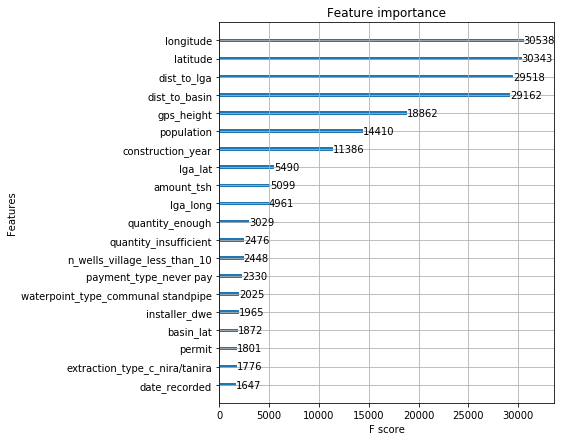

In [37]:
fig, ax = plt.subplots(figsize = (6, 7))
xgb.plot_importance(xgbc, max_num_features = 20, ax = ax)